In [1]:
# Run this to use from colab environment

import zipfile
import os
import pandas as pd
import numpy as np

with zipfile.ZipFile('ecg/ecg_data.zip', 'r') as zip_ref: #TODO: let hierop voor inleveren
    zip_ref.extractall('ecg')

data = pd.read_csv('ecg/ecg_data.csv', index_col=0)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

The number of samples: 827
The number of columns: 9001


In [2]:
from sklearn.model_selection import train_test_split, StratifiedKFold

# Splits features en labels
X = data.iloc[:, :-1].values  # Alle kolommen behalve de laatste zijn de features
y = data.iloc[:, -1].values   # De laatste kolom is de label (0 of 1)

In [15]:
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

def evaluate_with_nested_cv(X, y, model, param_grid, use_scaling=True, n_splits_outer=2, n_splits_inner=2, n_iter=2):
    """
    Performs nested cross-validation for model selection and performance estimation.
    
    Args:
        X (np.ndarray): Feature matrix
        y (np.ndarray): Labels
        model: Classifier (e.g. SVC(), RandomForestClassifier())
        param_grid (dict): Hyperparameter grid for tuning
        use_scaling (bool): Whether to scale features (important for SVM)
        n_splits_outer (int): Folds for outer CV
        n_splits_inner (int): Folds for inner CV
        n_iter (int): Iterations for RandomizedSearchCV
        
    Returns:
        List of outer scores and their mean
    """
    # Outer train/test split, stratified
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    if use_scaling:
        scaler = StandardScaler()
        X_train_full = scaler.fit_transform(X_train_full)
        X_test = scaler.transform(X_test)

    inner_cv = StratifiedKFold(n_splits=n_splits_inner, shuffle=True, random_state=1)

    clf = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        scoring='roc_auc',
        n_iter=n_iter,
        cv=inner_cv,
        n_jobs=-1,
        random_state=1
    )
    clf.fit(X_train_full, y_train_full)
    best_model = clf.best_estimator_

    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]
    score = roc_auc_score(y_test, y_prob)

    # Classification report
    print("AUC:", score)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix')
    plt.show()

    return score, classification_report(y_test, y_pred, output_dict=True), cm


AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.90       137
           1       0.00      0.00      0.00        29

    accuracy                           0.83       166
   macro avg       0.41      0.50      0.45       166
weighted avg       0.68      0.83      0.75       166



c:\Users\groot\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\groot\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\groot\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


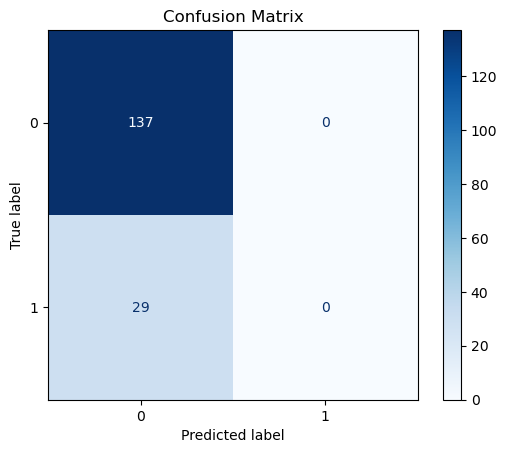

c:\Users\groot\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\groot\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\groot\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.5,
 {'0': {'precision': 0.8253012048192772,
   'recall': 1.0,
   'f1-score': 0.9042904290429044,
   'support': 137.0},
  '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 29.0},
  'accuracy': 0.8253012048192772,
  'macro avg': {'precision': 0.4126506024096386,
   'recall': 0.5,
   'f1-score': 0.4521452145214522,
   'support': 166.0},
  'weighted avg': {'precision': 0.6811220786761504,
   'recall': 0.8253012048192772,
   'f1-score': 0.74631198059565,
   'support': 166.0}},
 array([[137,   0],
        [ 29,   0]], dtype=int64))

In [16]:
from sklearn.svm import SVC

svm = SVC(probability=True, class_weight='balanced')
svm_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.1],
    'kernel': ['rbf']
}

evaluate_with_nested_cv(X, y, model=svm, param_grid=svm_grid, use_scaling=True)
